<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/11_3_CM_CR_ROCcurve_testBreast_Cancer_IDC_Prediction_Using_CNN_heesuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FALL 2022<br>
W207 Applied Machine Learning<br>
Heesuk Jang
 

#Predicting IDC with Breast Histopathology Images using CNN



In [1]:
import pandas as pd
import numpy as np
import os
import re
import random
import joblib
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *                            # confusion_matrix, log_loss, accuracy_score
from sklearn.model_selection import *                    # train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.preprocessing import *
# from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.linear_model import *                       # LinearRegression
from sklearn.discriminant_analysis import *
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
tf.get_logger().setLevel('INFO')

import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')

# Required to read the data from Kaggle
from google.colab import drive
# drive.mount('/content/gdrive')
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# CNN - ML pipeline

  1) EDA and Image Visualization<br>
  2) Randomly sample from training/test/validation = 800/ 200/ 200 (66%/ 17%/ 17%)<br>
  3) Image Transformations<br>
> Image resize<br>
> Image normalization to [0, 1]<br>
  
  4) [Image Augmentations](https://iq.opengenus.org/data-augmentation/)<br>
> Adjust brightness<br>
> Adjust contrast<br>
> Flip left and right<br>
> Rotate 90 degrees<br>

 5) CNN Model using Tensorflow Keras API<br>
> Build model<br>
> Compile model<br>
> Fit model<br>

 6) Evaluate the Model<br>
 : Determine how good our trained model applies in predicting unseen (test) data.
> model.**evaluate**<br>
> model.**predict**<br>
> Evaluation Metrics:  True Labels VS. Predicted Labels<br>

 7) Hyper Parameter Tuning<br>
> Optimizer<br>
> Learning Rate<br>
> Dropout ratio<br>
> Number of Epochs<br>
> Contrast Factor<br>
> Delta<br>









In [2]:
%pwd

'/content'

In [3]:
# !unzip gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip

#replace these paths with the paths of your 
val_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Validate'
train_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train'
test_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Test'
directory_path = '/content/gdrive/MyDrive/Kaggle/CNN_IDC'

In [4]:
def get_paths(directory):
  all_path = []
  idc_image_path = []
  idc_image_label = []

  for dir, subdir, files in os.walk(directory):
    path = dir + "/"
    all_path.append(path)

  for i in range(len(all_path)):
    for file in os.listdir(all_path[i]):
      test = file
      path = all_path[i] + test
      if path.lower().endswith('.png'):
        idc_image_path.append(path)

  for i in range(len(idc_image_path)):
    split_test = idc_image_path[i]
    split_path = split_test.split("/")
    directory_name = split_path[7]
    idc_image_label.append('class_' + split_path[8])
    # idc_image_label.append(str(split_path[8]))
  return idc_image_path, idc_image_label, directory_name

In [5]:
train_paths, train_labels, train_dir = get_paths(train_image_directory)
val_paths, val_labels, val_dir = get_paths(val_image_directory)
test_paths, test_labels, test_dir = get_paths(test_image_directory)

In [6]:
print(train_labels[:5])
print(train_labels[-5:])

print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))
print(len(val_paths), len(val_labels))

['class_0', 'class_0', 'class_0', 'class_0', 'class_0']
['class_1', 'class_1', 'class_1', 'class_1', 'class_1']
800 800
200 200
200 200


In [7]:
print(train_paths[:2])
print(train_labels[:10])
print(train_dir)

['/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/12880_idx5_x451_y701_class0.png', '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/9345_idx5_x2001_y2001_class0.png']
['class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0']
Train


In [8]:
def create_dataframes(idc_image_path, idc_image_label, directory_name):
  same_name = directory_name.lower() + '_'
  #creating the dataframes that we will be passing to our generators
  idc_data_cleaned = {'path': idc_image_path,
            'label': idc_image_label}
  idc_df = pd.DataFrame(idc_data_cleaned)
  df = idc_df.sample(frac = 1)
  print(df)
  csv_path = directory_path
  csv_file = df.to_csv(csv_path + '/' + same_name + 'idc_dataframe.csv')
  csv_file_path = csv_path + '/' + same_name + 'idc_dataframe.csv'
  return csv_file_path

In [9]:
train_dataframe = create_dataframes(train_paths, train_labels, train_dir)
print('type(train_dataframe): ',type(train_dataframe))
train_dataframe

                                                  path    label
160  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
314  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
422  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
350  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
781  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
..                                                 ...      ...
575  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
615  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
694  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
170  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
512  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1

[800 rows x 2 columns]
type(train_dataframe):  <class 'str'>


'/content/gdrive/MyDrive/Kaggle/CNN_IDC/train_idc_dataframe.csv'

In [10]:
train_dataframe = create_dataframes(train_paths, train_labels, train_dir)
train_generator = pd.read_csv(train_dataframe)

test_dataframe = create_dataframes(test_paths, test_labels, test_dir)
test_generator = pd.read_csv(test_dataframe)

val_dataframe = create_dataframes(val_paths, val_labels, val_dir)
val_generator = pd.read_csv(val_dataframe)

                                                  path    label
291  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
387  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
104  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
248  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
494  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
..                                                 ...      ...
13   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
692  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
415  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
94   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
319  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0

[800 rows x 2 columns]
                                                  path    label
128  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
21   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
78   /content/gd

In [11]:
# train_generator

In [12]:
# https://faroit.com/keras-docs/0.3.3/preprocessing/image/
data_generator = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
    #these are the augmentation features that you can adjust
    # link to read more about them https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None
    # rescale=1/255
)

data_generator = ImageDataGenerator()

train_data_generator = data_generator.flow_from_dataframe(
    train_generator,
    directory = None,
    x_col =  'path',
    y_col =  'label',
    weight_col=None,
    # featurewise_center = True,                     # transforms the images to 0 mean
    # featurewise_std_normalization = True,          # divide inputs by std of the dataset
    #readjust the target size based on max size of images
    target_size=(50, 50),
    color_mode="grayscale",
    class_mode="categorical",
    # class_mode="binary",
    batch_size=32,
    shuffle=True
    # seed=1234
    # validate_filenames=True
)

validation_data_generator = data_generator.flow_from_dataframe(
    val_generator,
    directory = None,
    x_col =  'path',
    y_col =  'label',
    weight_col=None,
    # featurewise_center = True,
    # featurewise_std_normalization = True,
    #readjust the target size based on max size of images
    target_size=(50, 50),
    color_mode="grayscale",
    class_mode="categorical",
    # class_mode="binary",
    batch_size=32,
    shuffle=True
    # seed=1234
    # validate_filenames=True
)

test_data_generator = data_generator.flow_from_dataframe(
    test_generator,
    directory = None,
    x_col =  'path',
    y_col =  'label',
    weight_col=None,
    # featurewise_center = True,
    # featurewise_std_normalization = True,
    #readjust the target size based on max size of images
    target_size=(50, 50),
    color_mode="grayscale",
    class_mode="categorical",
    # class_mode="binary",
    batch_size=32,
    shuffle=False              # Kesha set to shuffle=True but we don't want to shuffle our testing data around, which it does so by default
    # seed=1234
    # validate_filenames=True
)

Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [13]:
img_height = 50
img_width = 50
img_channel = 1

In [14]:
def get_doc_id_model():
  return tf.keras.Sequential([
                          # 1st Cov2d layer with input shape
                           keras.layers.Conv2D(input_shape = (img_height, img_width, img_channel), 
                                               filters=32, 
                                               kernel_size=(3, 3),
                                               padding='same',          # means add enough padding to the image so that the output feature map has the same dimension as the initial image. 
                                               activation='relu'),
                              
                           # 1st MaxPooling2D layer
                           keras.layers.MaxPooling2D(pool_size=(2, 2),
                                                  strides=(2, 2)),
                              
                           # 2nd Cov2d layer
                           keras.layers.Conv2D(filters=64, 
                                               kernel_size=(3, 3), 
                                               padding='same', 
                                               activation='relu'),
                              
                          # 2nd MaxPooling2D layer 
                           keras.layers.MaxPooling2D(pool_size=(2, 2),
                                                  strides=(2, 2)),
                          
                          # 3rd Cov2d layer
                           keras.layers.Conv2D(filters=128, 
                                               kernel_size=(3, 3), 
                                               padding='same', 
                                               activation='relu'),
                              
                          # 3rd MaxPooling2D layer
                           keras.layers.MaxPooling2D(pool_size=(2, 2), 
                                                  strides=(2, 2)),
                              
                          # flatten layer
                           keras.layers.Flatten(),
                           
                          #  fully connected layer
                           keras.layers.Dense(units = 256, 
                                              activation = 'relu'),
                           
                          #  keras.layers.Dense(units = 512, 
                          #                     activation = 'relu'),

                          #  Output layer - need 2 neurons with softmax (multi-class) activation
                           keras.layers.Dense(units = 2, 
                                              activation = 'softmax')
                           
                          #  Output layer - need 1 neuron with sigmoid (binary-class) activation
                          #  keras.layers.Dense(units = 1, 
                          #                     activation = 'sigmoid')
])

In [15]:
from tensorflow import keras

model = get_doc_id_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001), 
                    loss=keras.losses.categorical_crossentropy, 
                    metrics=['accuracy']
              )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [16]:
# tf.keras.callbacks.EarlyStopping => Stop training when a monitored metric has stopped improving.
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# This callback will stop the training when there is no improvement in the val_acc for 6 consecutive epochs
val_acc_early_stopping = EarlyStopping(monitor = 'loss',    # monitor = 'val_acc'
                                       patience = 6,        # Number of epochs with no improvement after which training will be stopped.
                                       verbose = 1,         # 1: displays messages when the callback takes an action
                                       mode = 'auto')

In [17]:
history = model.fit(train_data_generator,
                 epochs=7,
                 callbacks=[val_acc_early_stopping],
                 validation_data = validation_data_generator
                 )
# len(history.history['val_accuracy'])

Epoch 1/7
25/25 [==============================] - 11s 386ms/step - loss: 12.5351 - accuracy: 0.5125 - val_loss: 0.6385 - val_accuracy: 0.6400
Epoch 2/7
25/25 [==============================] - 11s 450ms/step - loss: 0.6490 - accuracy: 0.6125 - val_loss: 0.5966 - val_accuracy: 0.7000
Epoch 3/7
25/25 [==============================] - 9s 338ms/step - loss: 0.5847 - accuracy: 0.7113 - val_loss: 0.6404 - val_accuracy: 0.6150
Epoch 4/7
25/25 [==============================] - 5s 213ms/step - loss: 0.5711 - accuracy: 0.6875 - val_loss: 0.5873 - val_accuracy: 0.6900
Epoch 5/7
25/25 [==============================] - 5s 210ms/step - loss: 0.5252 - accuracy: 0.7350 - val_loss: 0.5916 - val_accuracy: 0.7100
Epoch 6/7
25/25 [==============================] - 5s 214ms/step - loss: 0.5069 - accuracy: 0.7375 - val_loss: 0.6363 - val_accuracy: 0.6650
Epoch 7/7
25/25 [==============================] - 5s 212ms/step - loss: 0.4365 - accuracy: 0.8000 - val_loss: 0.6412 - val_accuracy: 0.6900


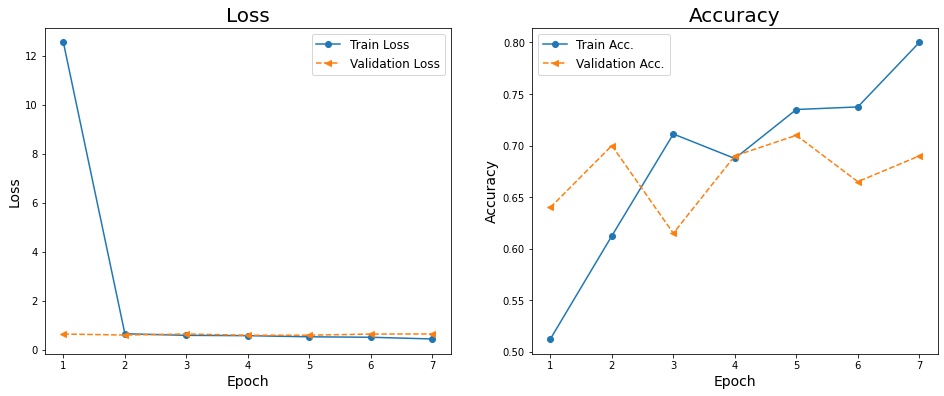

In [18]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1
# print(x_arr)

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=14)
ax.set_ylabel('Loss', size=14)
ax.set_title('Loss', size=20)

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train Acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=14)
ax.set_ylabel('Accuracy', size=14)
ax.set_title('Accuracy', size=20);

In [19]:
eval_train = model.evaluate(train_data_generator)
print(f'Train Accuracy: {eval_train[1]*100:.2f}%')
print()
eval_test = model.evaluate(test_data_generator)
print(f'Test Accuracy: {eval_test[1]*100:.2f}%\n')

25/25 [==============================] - 2s 77ms/step - loss: 0.3767 - accuracy: 0.8438
Train Accuracy: 84.38%

7/7 [==============================] - 1s 69ms/step - loss: 0.5136 - accuracy: 0.7700
Test Accuracy: 77.00%



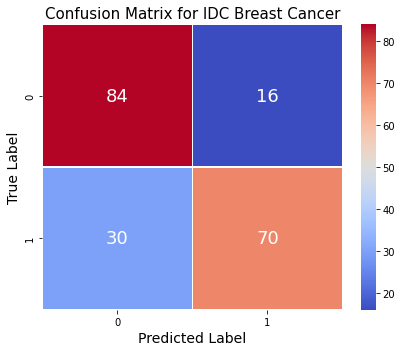

In [56]:
import itertools
num_of_test_samples = len(test_labels)
batch_size = 32

y_true = test_data_generator.classes
y_pred = model.predict_generator(test_data_generator, num_of_test_samples // batch_size + 1)
y_pred = np.argmax(y_pred, axis=1)     # return the indicies of the max values along the axis (axis=1: each row)


plt.figure(figsize=(6,5))
conf_max = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_max, annot=True, cmap='coolwarm', annot_kws={'fontsize':18}, linewidth=0.5, fmt='d')

plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix for IDC Breast Cancer', fontsize=15)
plt.tight_layout()


In [57]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()     # np.ravel(): returns contiguous flattened array (1D array with all the input-array elements and with the same type as it)
print(f'True Negatives (TN): {tn}\nTrue Positives (TP): {tp}\nFalse Negatives (FN): {fn}\nFalse Positives (FP): {fp}')

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = (2*precision*recall)/(precision+recall)

print(f'\nRecall of the model = {round(recall, 2)}\nPrecision of the model = {round(precision, 2)}\nF1_Score of the model = {round(f1_score, 2)}')

True Negatives (TN): 84
True Positives (TP): 70
False Negatives (FN): 30
False Positives (FP): 16

Recall of the model = 0.7
Precision of the model = 0.81
F1_Score of the model = 0.75


In [58]:
print(classification_report(y_true, y_pred, target_names=['Non-IDC', 'IDC']))

              precision    recall  f1-score   support

     Non-IDC       0.74      0.84      0.79       100
         IDC       0.81      0.70      0.75       100

    accuracy                           0.77       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.78      0.77      0.77       200



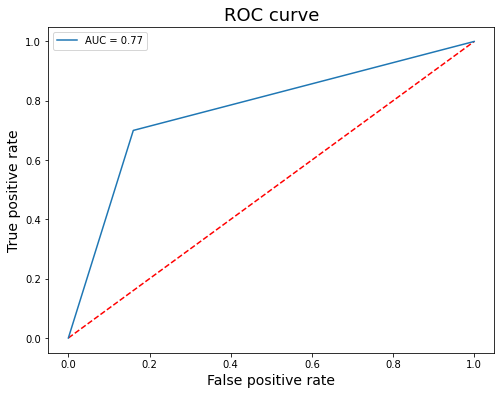

In [52]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve

roc_log = roc_auc_score(y_true, y_pred)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_true, y_pred)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.2f}'.format(area_under_curve))
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('ROC curve', fontsize=18)
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()